## Recommender Systems in python 101
RecSys is to recommend relevant items for users based on their prefreences. 

Preference and relevance are subjective and they ar egenerally inferred by items users have consumed previously. 

Three main RecSys techniques:
1. Collaborative Filtering: This method makes automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on a set of items, A is more likely to have B's opinion for a given item than that of a randomly chosen person. 
2. Content based filtering: This method uses only information about the description and attributes of the items users has previously consumed to model user's preferences. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past (or is examining in the present). In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended.  
3. Hybrid: Recent research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem. (The hybrid approach can be used to overcome common problems in recommender systems such as cold start and sparsity problem. 

Data source: https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop 
Articles sharing and reading from CI&T deskdrop
Logs of users interactions on shared articles for content recommender systems 

3 types of methods are used to show case how this work

In [2]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

## Loading data: CI&T deskdrop dataset
Contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article' lang (Portuguese: pt or English: en) and information about the user who shared the article (author).

There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.

For the sake of simplicity, we only consider here the "CONTENT SHARED" event type, assuming (naively) that all articles were available during the whole one year period. For a more precise evaluation (and higher accuracy), only articles that were available at a given time should be recommended, but we let this exercice for you.

### Shared_articles.csv


In [7]:
articles_df=pd.read_csv("shared_articles.csv")
articles_df=articles_df[articles_df['eventType']=='CONTENT SHARED']
articles_df.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


### users_interactions.csv
User interactions for eventType:
1. View
2. Like
3. Comment Created:
4. Follow
5. Bookmark

In [9]:
interactions_df=pd.read_csv("users_interactions.csv")
interactions_df.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Data Munging
There are different interactions types, associate them with a weight or strength. Some interactions with the content indicates a higher level of interest of the user on the item rather than a simple view.

In [10]:
event_type_strength={
    'VIEW':1.0,
    'LIKE':2.0,
    'BOOKMARK':2.5,
    'FOLLOW':3.0,
    'COMMENT CREATED':4.0,
}

interactions_df['eventStrength']=interactions_df['eventType'].apply(lambda x:event_type_strength[x])




Recommender systems have a problem known as ***user cold-start***, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences.  
For this reason, we are keeping in the dataset only users with at leas 5 interactions.

In [13]:
# Slicing the data to get an aggregate of users' whose interactions occur more than 5 times 

users_interactions_count_df=interactions_df.groupby(["personId","contentId"]).size().groupby('personId').size()
users_interactions_count_df.head()

personId
-9223121837663643404    43
-9212075797126931087     5
-9207251133131336884     7
-9199575329909162940    11
-9196668942822132778     7
dtype: int64

In [20]:
print('# users: %d' % len(users_interactions_count_df))

# users: 1895


In [25]:
# Further slice the data to get user interactions with more than 5
users_with_enough_interactions_df=users_interactions_count_df[users_interactions_count_df>=5].reset_index()[["personId"]]

users_with_enough_interactions_df.head()


,personId
0,-9223121837663643404
1,-9212075797126931087
2,-9207251133131336884
3,-9199575329909162940
4,-9196668942822132778


In [27]:
print('# users with at least 5 interactions: %d' % len(users_with_enough_interactions_df))

# users with at least 5 interactions: 1140


In [28]:
# Doing a right join to only look at the users that have enough interactions 
print('# of interactions: %d' % len(interactions_df))
interactions_from_selected_users_df = interactions_df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('# of interactions from users with at least 5 interactions: %d' % len(interactions_from_selected_users_df))


# of interactions: 72312
# of interactions from users with at least 5 interactions: 69868


## Users' interest level
User interest on a given article are expressed in the form of several different types of interactions. Therefore the general "interest" level is modelled using all users' interactions on a given article (like, comment, view etc.)

The interest level is a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [33]:
#Smoothed user preferences to get a smooth distribution esp on the column of event strength
# where first aggregation sum is created and then smoothed
def smooth_user_preference(x):
    return math.log(1+x,2)

interactions_full_df=interactions_from_selected_users_df \
                        .groupby(["personId",'contentId'])['eventStrength'].sum() \
                        .apply(smooth_user_preference).reset_index()

print("# of unique user/item interactions: %d" % len(interactions_full_df))

# of unique user/item interactions: 39106


In [32]:
interactions_full_df.head()

,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


## Evaluation
Evaluation is important. This is to objectively compare different algorithms and hyperparameters for models. 

Here a simple cross validation approach is used where 20% holdout is created. 

A more robust evaluation approach could be to split train and test sets by a reference data, where the train set is composed by all intearctions before that date, and the test set are interactions after that date. 

**The second approach can be used to simulate how the recsys would perform in a production predicting future users interactions**

In [34]:
interactions_train_df,interactions_test_df=train_test_split(interactions_full_df,\
                                                           stratify=interactions_full_df['personId'],
                                                           test_size=0.2,random_state=42)

In [36]:
print("# interactions on Train set: %d" % len(interactions_train_df))
print(" # interactions on Test set: %d" % len(interactions_test_df))

# interactions on Train set: 31284
 # interactions on Test set: 7822


### Evaluation metrics for recommender systems
Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items that user has actually interacted in test set. 

The evaluation method:
* For each user
    * For each item the user has interacted in test set
        * Sample 100 other items the user has never interacted.   
        Ps. Here we naively assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted ("non-relevant!) items
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N accuracy metrics



The Top-N accuracy metric choosen was **Recall@N** which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.  
Ps. Other popular ranking metrics are **NDCG@N** and **MAP@N**, whose score calculation takes into account the position of the relevant item in the ranked list (max. value if relevant item is in the first position). You can find a reference to implement this metrics in this [post](http://fastml.com/evaluating-recommender-systems/).

### Building this evaluation metrics in python

In [38]:
# Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df=interactions_full_df.set_index("personId")
interactions_train_indexed_df=interactions_train_df.set_index("personId")
interactions_test_indexed_df=interactions_test_df.set_index("personId")



In [40]:
# Create a function to get the items users have interacted to build the top n accuracy metrics 
def get_items_interacted(person_id,interactions_df):
    # get the users' data and merge in the movie information.
    interacted_items=interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items)==pd.Series else [interacted_items])

In [41]:
# Top N accuracy metrics consts

EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS=100

class ModelEvaluator:
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['contentId'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()    

## Popularity model

A common (and usually hard-to-beat) baseline approach is the Popularity model. This model is not actually personalized - it simply recommends to a user the most popular items that the user has not previously consumed. As the popularity accounts for the "wisdom of the crowds", it usually provides good recommendations, generally interesting for most people.   
Ps. The main objective of a recommender system is to leverage the long-tail items to the users with very specific interests, which goes far beyond this simple technique.

In [42]:
# Compute the most popular items
item_popularity_df=interactions_full_df.groupby("contentId")['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head(10)


,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [43]:
class PopularityRecommender:
    
    MODEL_NAME = 'Popularity'
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)



Popularity model is used to create a baseline for other recommender systems. 

Here we perform the evaluation of the Popularity model, according to the method described above.  
It achieved the **Recall@5** of **0.2417**, which means that about **24%** of interacted items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And **Recall@10** was even higher (**37%**), as expected.  
It might be surprising to you that usually Popularity models could perform so well!

In [44]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
1139 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.2417540271030427, 'recall@10': 0.37292252620813093}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,50,28,192,0.260417,0.145833
17,-2626634673110551643,25,12,134,0.186567,0.089552
16,-1032019229384696495,23,13,130,0.176923,0.100000
10,-1443636648652872475,9,5,117,0.076923,0.042735
82,-2979881261169775358,40,25,88,0.454545,0.284091
161,-3596626804281480007,18,12,80,0.225000,0.150000
65,1116121227607581999,33,20,73,0.452055,0.273973
81,692689608292948411,23,17,69,0.333333,0.246377
106,-9016528795238256703,18,14,69,0.260870,0.202899
52,3636910968448833585,28,21,68,0.411765,0.308824


## Content based filtering model
Content based filtering approaches leverage description or attributes from items the users have interacted to recommend similar items. It depends only on the user previous choices, this method is robust to avoid the cold-start problem. 

For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.  
Here we are using a very popular technique in information retrieval (search engines) named [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same [Vector Space Model](https://en.wikipedia.org/wiki/Vector_space_model), it is to compute similarity between articles.  
See this [presentation](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) (from slide 30) for more information on TF-IDF and Cosine similarity.

In [45]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = articles_df['contentId'].tolist()
tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + "" + articles_df['text'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.   

In [46]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = interactions_full_df[interactions_full_df['contentId'] \
                                                   .isin(articles_df['contentId'])].set_index('personId')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [48]:
user_profiles = build_users_profiles()
len(user_profiles)

1140

In [50]:
myprofile = user_profiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.305655
1,machine learning,0.255557
2,machine,0.246095
3,google,0.208590
4,data,0.172509
5,ai,0.136818
6,algorithms,0.102396
7,graph,0.098438
8,like,0.096970
9,language,0.083993


In [53]:
# Actual implementation of the content based recommender 
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(articles_df)

In [54]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1139 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.41459984658655075, 'recall@10': 0.5241626182562005}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,26,16,192,0.135417,0.083333
17,-2626634673110551643,35,21,134,0.261194,0.156716
16,-1032019229384696495,34,22,130,0.261538,0.169231
10,-1443636648652872475,54,34,117,0.461538,0.290598
82,-2979881261169775358,15,8,88,0.170455,0.090909
161,-3596626804281480007,23,14,80,0.287500,0.175000
65,1116121227607581999,15,10,73,0.205479,0.136986
81,692689608292948411,20,11,69,0.289855,0.159420
106,-9016528795238256703,10,5,69,0.144928,0.072464
52,3636910968448833585,11,4,68,0.161765,0.058824


## Collaborative Filtering Model
There are two primary techniques to implementing collaborative filtering:
1. Memory-based: this uses the memory of previous users' interactions to compute users similarities based on items they've interacted(user-based approach) or compute items similarities based on the users that have interacted with them (item based approach). A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. A nice Python implementation of this approach in available in [Crab](http://muricoca.github.io/crab/).
2. Model-based: Models are developed using different machine learning algorithms to recommend items to users. There are many model based CF algorithms such as neural networks, bayesian networks, clustering models, latetn factor models such as singular value decomposition and probabilistic latent semantic analysis

## Matrix Factoriazation
Latent factor models compress user-item matrix into a low-dimensional representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.  
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.  

Here we a use popular latent factor model named [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition). There are other matrix factorization frameworks more specific to CF you might try, like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec) or [python-recsys](https://github.com/ocelma/python-recsys). We chose a [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html) implemenation of SVD because it is available on Kaggle kernels.  
Ps. See an example of SVD on a movies dataset in this [blog post](https://beckernick.github.io/matrix-factorization-recommender/).

An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to  memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.

In [55]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)

users_items_pivot_matrix_df.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
users_items_pivot_matrix = users_items_pivot_matrix_df.as_matrix()
users_items_pivot_matrix[:10]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 2., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [58]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [59]:
U.shape

(1140, 15)

In [60]:
Vt.shape

(15, 2926)

In [61]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [62]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.01039915,  0.00081872, -0.01725263, ...,  0.00140708,
         0.0110647 ,  0.00226063],
       [-0.00019285, -0.00031318, -0.00264624, ...,  0.00251658,
         0.00017609, -0.00189488],
       [-0.01254721,  0.0065947 , -0.00590676, ...,  0.00698975,
        -0.01015696,  0.01154572],
       ...,
       [-0.02995379,  0.00805715, -0.01846307, ..., -0.01083078,
        -0.00118591,  0.0096798 ],
       [-0.01845505,  0.00467019,  0.01219602, ...,  0.00409507,
         0.00019482, -0.00752562],
       [-0.01506374,  0.00327732,  0.13391269, ..., -0.01191815,
         0.06422074,  0.01303244]])

In [63]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.010399,-0.000193,-0.012547,0.052958,-0.010035,-0.005412,-0.003918,0.049302,-0.013458,-0.020052,...,-0.005306,-0.089463,-0.000048,0.015023,0.020953,-0.009394,-0.019114,-0.029954,-0.018455,-0.015064
-9216926795620865886,0.000819,-0.000313,0.006595,-0.000649,0.000151,0.000338,0.000197,0.000861,0.002341,0.001765,...,0.000095,0.013915,0.000506,0.001460,0.014863,0.000940,0.002391,0.008057,0.004670,0.003277
-9194572880052200111,-0.017253,-0.002646,-0.005907,-0.003666,0.021300,-0.001278,0.029100,-0.014730,-0.023410,0.004950,...,0.011529,0.046012,0.010485,0.018768,0.150362,0.019052,0.023870,-0.018463,0.012196,0.133913
-9192549002213406534,0.035081,0.000391,-0.029046,-0.007702,0.017615,0.005496,0.013435,0.057563,0.047532,0.004209,...,0.020149,0.260317,0.007923,-0.008079,0.034164,0.011558,0.013793,-0.010138,0.025703,0.095753
-9190737901804729417,0.019939,-0.004799,0.006684,0.006363,-0.001997,0.002356,0.003876,0.004118,-0.027098,0.019793,...,0.003719,0.004478,0.001917,0.000341,-0.034535,-0.001160,0.001307,0.002957,0.005991,-0.015662
-9189659052158407108,0.008661,0.006604,0.001463,-0.002918,0.008551,-0.001637,0.005443,0.002193,0.023148,0.021311,...,0.024496,0.090091,-0.002703,0.001883,0.098925,0.008484,0.014513,0.016385,0.021794,0.068420
-9176143510534135851,0.046426,0.006374,0.013802,0.010265,-0.002538,-0.004453,0.016615,0.023070,0.059582,0.057307,...,0.003667,0.073024,-0.015438,0.001199,-0.005606,-0.000307,0.005250,0.041064,0.030733,0.037113
-9172673334835262304,0.005083,0.000618,0.002845,-0.001103,0.000398,0.000754,0.001346,0.002713,-0.002811,0.003930,...,0.005625,0.019382,0.000544,-0.000992,-0.008110,0.000156,0.003408,0.003614,0.007607,-0.003650
-9171475473795142532,0.024453,-0.000761,0.000963,-0.002817,0.002466,0.001215,0.009339,-0.003530,-0.007137,0.023221,...,0.009667,0.017163,0.000424,0.000060,-0.016698,0.002045,0.007644,0.000955,0.011074,-0.006657


In [64]:
len(cf_preds_df.columns)

1140

In [65]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['contentId'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5 (33%)** and **Recall@10 (46%)** values higher than Popularity model, but lower than Content-Based model.  
It appears that for this dataset, Content-Based approach is being benefited by the rich item attributes (text) for a better modeling of users preferences.

In [66]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1139 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.33405778573254924, 'recall@10': 0.46816670928151366}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,45,21,192,0.234375,0.109375
17,-2626634673110551643,56,30,134,0.417910,0.223881
16,-1032019229384696495,34,16,130,0.261538,0.123077
10,-1443636648652872475,51,38,117,0.435897,0.324786
82,-2979881261169775358,48,39,88,0.545455,0.443182
161,-3596626804281480007,34,22,80,0.425000,0.275000
65,1116121227607581999,32,24,73,0.438356,0.328767
81,692689608292948411,21,16,69,0.304348,0.231884
106,-9016528795238256703,28,20,69,0.405797,0.289855
52,3636910968448833585,30,23,68,0.441176,0.338235


## hybrid Recommender Implementation 

What if we combine Collaborative Filtering and Content-Based Filtering approaches?    
Would that provide us with more accurate recommendations?    
In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.  
Let's build a simple hybridization method, by only multiply the CF score with the Content-Based score, and ranking by resulting score.

In [67]:
class HybridRecommender:
    
    MODEL_NAME = 'Hybrid'
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        #Getting the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose,
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, items_to_ignore=items_to_ignore, verbose=verbose, 
                                                           topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df,
                                   how = 'inner', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId')
        
        #Computing a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF']
        
        #Sorting recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return recommendations_df
    
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, cf_recommender_model, articles_df)

m
**It appears we have a new champion!**  
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a **Recall@5** of **43%** and **Recall@10** of **53%**

In [68]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)
print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1139 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.4337765277422654, 'recall@10': 0.537969828688315}


,_person_id,hits@10_count,hits@5_count,interacted_count,recall@10,recall@5
76,3609194402293569455,40,27,192,0.208333,0.140625
17,-2626634673110551643,56,38,134,0.417910,0.283582
16,-1032019229384696495,35,27,130,0.269231,0.207692
10,-1443636648652872475,52,37,117,0.444444,0.316239
82,-2979881261169775358,31,26,88,0.352273,0.295455
161,-3596626804281480007,28,20,80,0.350000,0.250000
65,1116121227607581999,21,16,73,0.287671,0.219178
81,692689608292948411,23,14,69,0.333333,0.202899
106,-9016528795238256703,19,14,69,0.275362,0.202899
52,3636910968448833585,19,16,68,0.279412,0.235294


## Comparing the methods


In [69]:
global_metrics_df = pd.DataFrame([pop_global_metrics, cf_global_metrics, cb_global_metrics, hybrid_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@10,recall@5
modelName,,
Popularity,0.372923,0.241754
Collaborative Filtering,0.468167,0.334058
Content-Based,0.524163,0.414600
Hybrid,0.537970,0.433777


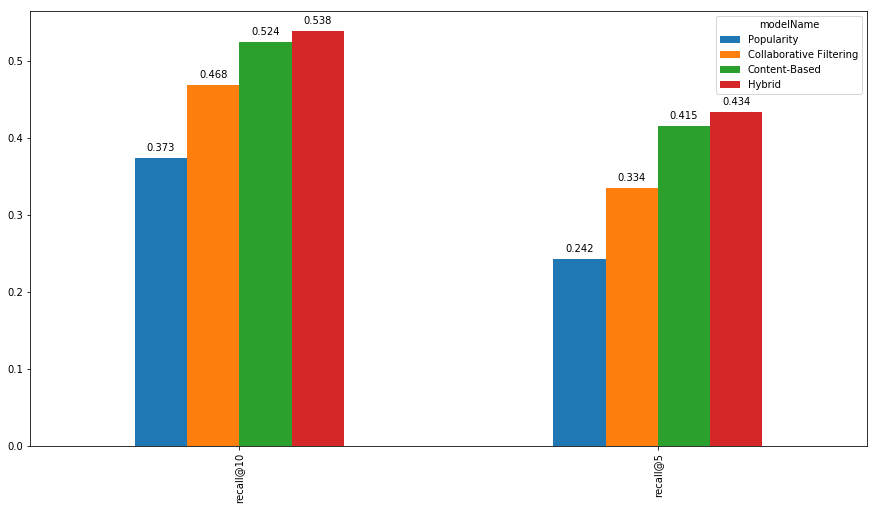

In [70]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

### Conclusion and next steps
In this notebook, we've explored and compared the main Recommender Systems techniques on [CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop) dataset. It could be observed that for articles recommendation, content-based filtering and a hybrid method performed better than Collaborative Filtering alone.  

There is large room for improvements of the results. Here are some tips:
- In this example, we've completely ignored the time, considering that all articles were available to be recommended to users at any time. A better approach would be to filter only articles that were available for users at a given time.
- You could leverage the available contextual information to model users preferences across time (period of day, day of week, month), location (country and state/district) and devices (browser, mobile native app).  
This contextual information can be easily incorporated in [Learn-to-Rank](https://en.wikipedia.org/wiki/Learning_to_rank) models (like XGBoost Gradient Boosting Decision Trees with ranking objective) or Logistic models (with categorical features [One-Hot encoded](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) or [Feature Hashed](https://en.wikipedia.org/wiki/Feature_hashing)). Take a look in the summary my solution shared for [Outbrain Click Prediction](https://www.kaggle.com/c/outbrain-click-prediction/discussion/27897#157215) competition. 
- Those basic techniques were used for didactic purposes. There are more advanced techniques in RecSys research community, specially advanced Matrix Factorization and Deep Learning models.  

You can know more about state-of-the-art methods published in Recommender Systems on [ACM RecSys conference](https://recsys.acm.org/).  
If you are more like practioner than researcher, you might try some Collaborative Filtering frameworks in this dataset, like [surprise](https://github.com/NicolasHug/Surprise), [mrec](https://github.com/Mendeley/mrec),  [python-recsys](https://github.com/ocelma/python-recsys) and [Spark ALS Matrix Factorization](https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html) (distributed implementation for large datasets).  
Take a look in this [presentation](https://www.slideshare.net/gabrielspmoreira/discovering-users-topics-of-interest-in-recommender-systems-tdc-sp-2016) where I describe a production recommender system, focused on Content-Based Filtering and Topic Modeling techniques.